# 3D DeepLabCut Toolbox
https://github.com/DeepLabCut/DeepLabCut

This notebook will highlight the functionality of the newly released 3D project option (as of **2.0.7+**).

We recommend you look through these commands, and then you can easily modify this notebook for your own projects.

**In summary, the new functionality will:**
- allow you to calibrate your cameras using checkerboard images
- compute and fix camera distortions
- convert your 2D DeepLabCut tracking to 3D
- allow for plotting in 3D space

### Create a New 3D Project:

You will run this first function **one** time per project; a project is defined as a given set of cameras and calibration images. You can always analyze new videos within this project.

The function create_new_project_3d creates a new project directory specifically for converting the 2D pose to 3D pose, required subdirectories, and a basic 3D project configuration file. Each project is identified by the name of the project (e.g. Task1), name of the experimenter (e.g. YourName), as well as the date at creation.

Thus, this function requires the user to input the enter the name of the project, the name of the experimenter and number of cameras to be used. Currently, DeepLabCut supports triangulation using 2 cameras, but will expand to more than 2 cameras in a future version.

Optional arguments specify the working directory, i.e. where the project directory will be created. If the optional argument working_directory is unspecified, the project directory is created in the current working directory. Please note that the Full path of the 3D project configuration file will be referenced as ``config_path3d``.

NOTE: Be sure you are inside your DLC anaconda environment!

In [32]:
import deeplabcut
import numpy as np
import pandas as pd
from deeplabcut.pose_estimation_3d import triangulation, plotting3D
from deeplabcut.utils import auxiliaryfunctions, auxiliaryfunctions_3d, auxfun_multianimal, make_labeled_video
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FFMpegWriter
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
%matplotlib inline



In [3]:
config_path = Path("AcinoSet-Cam12-testDLC-2025-10-31-3d/config.yaml")
print(config_path)

AcinoSet-Cam12-testDLC-2025-10-31-3d\config.yaml


In [2]:
#Setup your project variables:
YourName = 'testDLC'
YourExperimentName = 'AcinoSet-Cam12'

In [12]:
config_path = deeplabcut.create_new_project_3d(YourExperimentName,YourName,num_cameras=2)

Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\calibration_images"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\undistortion"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\corners"
Created "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\removed_calibration_images"
Generated "C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\config.yaml"

A new project with name AcinoSet-Cam12-testDLC-2025-10-31-3d is created at C:\Users\locha\Documents\Work\3D-DLC-AcinoSet and a configurable file (config.yaml) is stored there. If you have not calibrated the cameras, then use the function 'calibrate_camera' to start calibrating the camera otherwise use the function ``triangulate`` to triangulate

**TIP 1:** you can also pass ``working_directory='Full path of the working directory'`` if you want to place this folder somewhere beside the current directory you are working in.

**TIP 2:** you can also place config_path3d in front of deeplabcut.create_new_project_3d to create a variable that holds the path to the config.yaml file, i.e. ``config_path3d=deeplabcut.create_new_project_3d(...``

In [9]:
#If you're loading an already created project, just set the 3D Project config_path variable:
#import os
#from pathlib import Path
#config_path3d = os.path.join(os.getcwd(),'testing3D-DeepLabCutTeam-2019-06-05-3d/config.yaml')
#print(config_path3d)

## Calibrate your cameras! 

(**CRITICAL!**) You must take images of a checkerboard to calibrate your images. Here are example boards you could print and use (mount them on a flat, hard surface!): https://markhedleyjones.com/projects/calibration-checkerboard-collection. 
- You must save the image pairs as **.jpg** files. 
- They should be named with the camera-# as the prefix, i.e. **camera-1-01.jpg** and **camera-2-01.jpg** for the first pair of images. 
- While taking the images:
     - Keep the orientation of the chessboard same and do not rotate more than 30 degrees. Rotating the chessboard circular will change the origin across the frames and may result in incorrect order of detected corners.

     - Cover several distances, and within each distance, cover all parts of the image view (all corners and center).

     - Use a checkerboard as big as possible, ideally with at least 8x6 squares.

     - Aim for taking at least 70 pair of images as after corner detection, some of the images might need to be discarded due to either incorrect corner detection or incorrect order of detected corners.
     
#### DEMO images:
 
Here, we used a standard set along with this notebook. These images are a part of the Camera Calibration ToolBox for Matlab; specifically example 5. The images can be downloaded at: https://data.caltech.edu/records/20164. After downloading, the calibration images can be found at ../calib_doc/htmls/calib_example.zip


If you wish to run this DEMO notebook, download the files and place inside the **calibration_images** directory. (To note, pairs 1 and 6 are not detected correctly, so please delete these images!). 


When acquiring calibration images from your own setup, it is recommended to take multiple pairs of image (around 50-70 pairs!).

The camera calibration is an **iterative process**, where the user needs to select a set of calibration images where the grid pattern is correctly detected. The function:``deeplabcut.calibrate_cameras(config_path)`` 
extracts the grid pattern from the calibration images and store them under the `corners` directory. The grid pattern could be 8x8 or 5x5 etc. We use a pattern of the 8x6 grid to find the internal corners of the checkerboard.

In some cases, it may happen that the corners are not detected correctly or the order of corners detected in the camera-1 image and camera-2 image is incorrect. We need to remove these pair of images as they will reduce the calibration accuracy.

**NEXT/if not done:** please place your (or demo) images into the **calibration_images** directory. 

### Edit the config.yaml file:
- change the camera names; i.e. if you do ""cam1, cam2"", or "camera-1, camera-2", or "left, right", etc.
- Note, that once this is set, you cannot edit these (they are used for other steps).

In [13]:
deeplabcut.calibrate_cameras(config_path, cbrow=6, cbcol=8, calibrate=False, alpha=0.9)

Corners extracted! You may check for the extracted corners in the directory C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\corners and remove the pair of images where the corners are incorrectly detected. If all the corners are detected correctly with right order, then re-run the same function and use the flag ``calibrate=True``, to calbrate the camera.


NOTE: you need to specify how many rows (``cbrow``) and columns (``cbcol``) your checkerboard has (i.e. the intersection points - see demo images if unclear). Also, first set the variable ``calibrate`` to **False**, so you can remove any faulty images. You need to  visually inspect the output to check for the detected corners and select those pair of images where the corners are correctly detected. 

Once all the set of images are selected (namely, delete from the folder any bad pairs!) where the corners and their orders are detected correctly, then the two cameras can be calibrated using:

**They will look like this (one example frame):**
<p align="center">
<img src="https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1559776966423-RATM6ZQT8JXHYAN768F6/ke17ZwdGBToddI8pDm48kKmw982fUOZVIQXHUCR1F55Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpw5XnxLBmEFHJGf_0qFdDpmIncOw4kq9OpCHNTYqzGO-E1YJr-Thht9Tdog4YtCwrE/right02_corner.jpg?format=500w" width="30%">
</p> 

In [14]:
deeplabcut.calibrate_cameras(config_path, cbrow=6, cbcol=8, calibrate=True, alpha=0.9)

Saving intrinsic camera calibration matrices for camera-1 as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Mean re-projection error for camera-1 images: 0.345 pixels 
Saving intrinsic camera calibration matrices for camera-2 as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Mean re-projection error for camera-2 images: 0.335 pixels 
Computing stereo calibration for 
Saving the stereo parameters for every pair of cameras as a pickle file in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\camera_matrix
Camera calibration done! Use the function ``check_undistortion`` to check the check the calibration


## Check for Undistortion:

In order to check how well the stereo calibration is, it is recommended to undistort the calibration images and the corner points using camera matrices and project these undistorted points on the undistorted images to check if they align correctly. This can be done in deeplabcut as:


All images are undistorted and stored in C:\Users\locha\Documents\Work\3D-DLC-AcinoSet\AcinoSet-Cam12-testDLC-2025-10-31-3d\undistortion
Use the function ``triangulate`` to undistort the dataframes and compute the triangulation


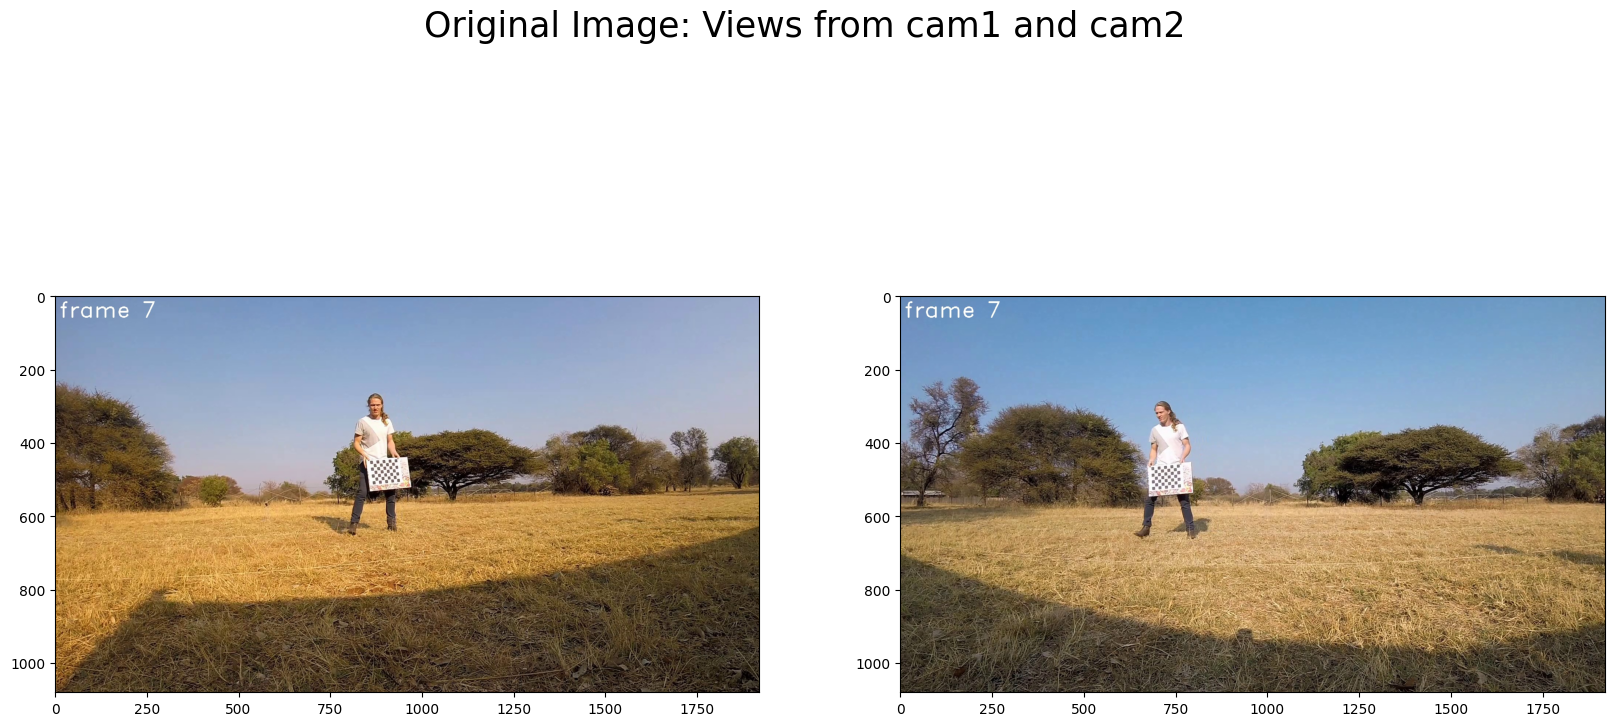

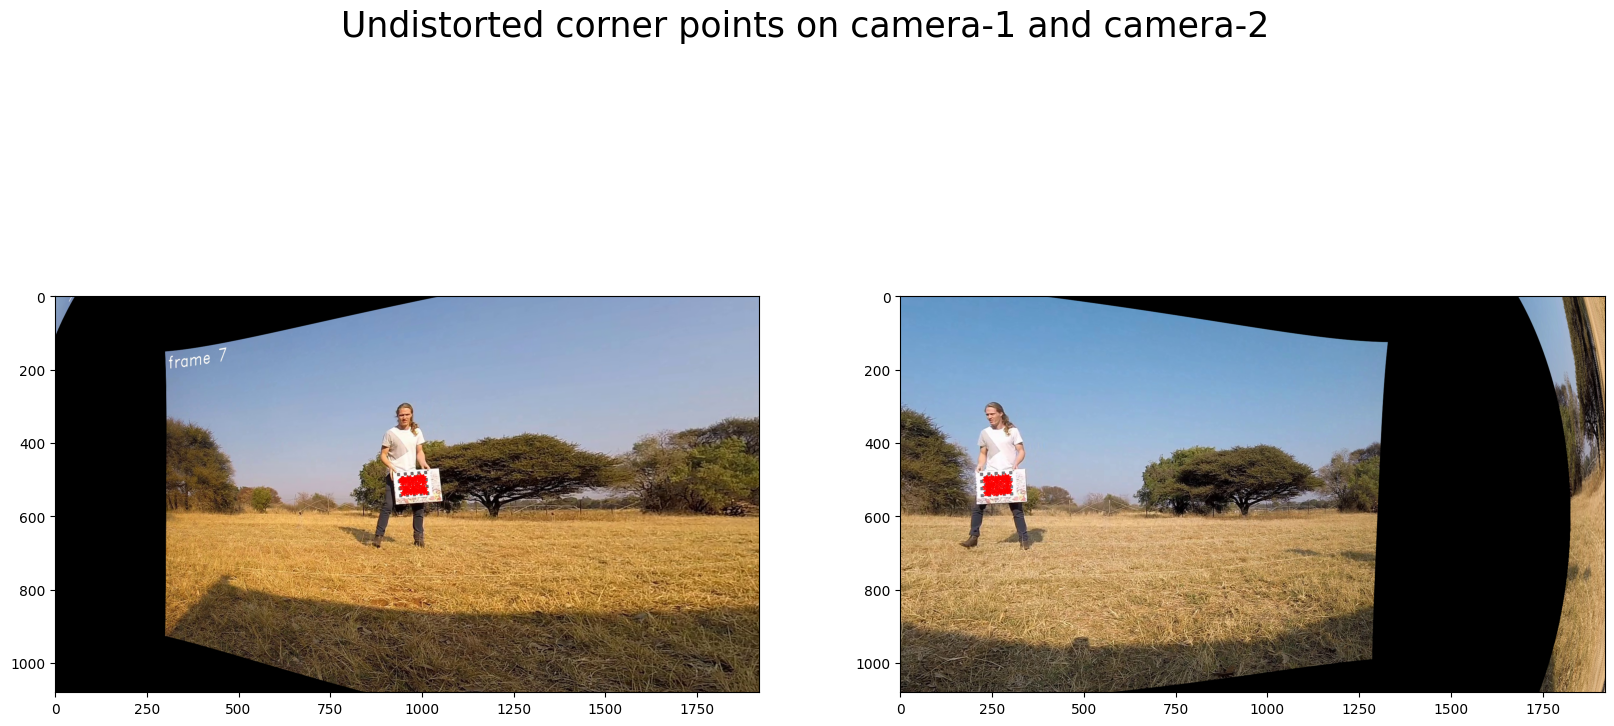

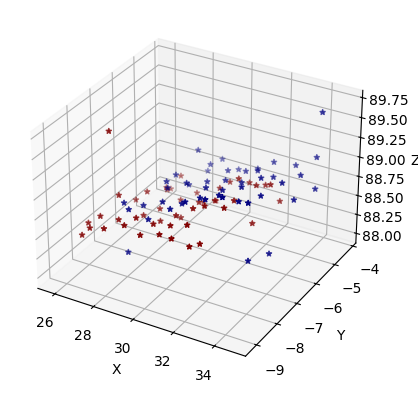

In [ ]:
deeplabcut.check_undistortion(config_path)

Each calibration image is undistorted and saved under the directory ``undistortion``. A plot with a pair of undistorted camera images with its undistorted corner points overlaid is also stored. Please visually inspect this image. All the undistorted corner points from all the calibration images are triangulated and plotted for the user to visualize for any undistortion related errors. If they are not correct, go check and revise the calibration images (then repeat the calirbation and this step)!

## Triangulation --> converting your 2D to 3D! 

If there are no errors in the undistortion, then the pose from the 2 cameras can be triangulated to get the 3D DeepLabCut coordinates!

(**CRITICAL!**) Name the video files in such a way that the file name contains the name of the cameras as specified in the ``config file``. e.g. if the cameras as named as ``camera-1`` and ``camera-2`` (or ``cam-1``, ``cam-2`` etc.) then the video filename must contain this naming, i.e. this could be named as ``rig-1-mouse-day1-camera-1.avi`` and ``rig-1-mouse-day1-camera-2.avi``. Notably, the videos do not need to be the same pixel size, but be sure they are similar in size to the calibration images (and they must be the same cameras used for calibration).

##  (**CRITICAL!**) Edit the config.yaml file: 
You must also edit the **3D project config.yaml** file to denote which DeepLabCut projects have the information for the 2D views. 

 - Of critical importance is that you need to input the **same** body part names as in the config.yaml file of the 2D project.
- You must set the snapshot to use inside the 2D config file (default is -1, namely the last training snapnot of the network). 
- You need to set a "scorer 3D" name; this will point to the project file and be set in future 3D output file names.
- You should define a "skeleton" here as well (note, this is not rigid, it just connects the points in the plotting step). Not every point needs to be "skeletonized", i.e. these points can be a subset of the full body parts list. The other points will just be plotted into the 3D space.



**Next,** pass the ``config_path3d`` and now the ``video_path``, which is the path to the **folder** where all the videos from two cameras are stored. The triangulation can be done in deeplabcut by typing:

In [16]:
video_list = [
    ["AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1.mp4", 
     "AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam2.mp4"]]
dataname = [
    Path("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1DLC_resnet152_CheetahOct14shuffle3_650000.h5"),
    Path("AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam2DLC_resnet152_CheetahOct14shuffle3_650000.h5")
]
cfg_3d = auxiliaryfunctions.read_config(config_path)
cam_names = cfg_3d["camera_names"]
pcutoff = cfg_3d["pcutoff"]
scorer_3d = cfg_3d["scorername_3d"]
cfg_2d = cfg_3d[str("config_file_" + cam_names[0])]
save_as_csv = True
video = video_list[0][0]
destfolder = Path(video).parents[0].as_posix() + "/"
output_file = destfolder + "vid1"
output_filename = output_file + "_" + scorer_3d
string_to_search = scorer_3d + ".h5"

In [8]:
print("Undistorting...")
(
    dataFrame_camera1_undistort,
    dataFrame_camera2_undistort,
    stereomatrix,
    path_stereo_file,
) = triangulation.undistort_points(
    config_path, dataname, str(cam_names[0] + "-" + cam_names[1])
)

Undistorting...


In [9]:
scorer_cam1 = dataFrame_camera1_undistort.columns.get_level_values(0)[0]
scorer_cam2 = dataFrame_camera2_undistort.columns.get_level_values(0)[0]

bodyparts = dataFrame_camera1_undistort.columns.get_level_values(
    "bodyparts"
).unique()

P1 = stereomatrix["P1"]
P2 = stereomatrix["P2"]
F = stereomatrix["F"]

print("Computing the triangulation...")
num_frames = dataFrame_camera1_undistort.shape[0]
### Assign nan to [X,Y] of low likelihood predictions ###
# Convert the data to a np array to easily mask out the low likelihood predictions
data_cam1_tmp = dataFrame_camera1_undistort.to_numpy().reshape(
    (num_frames, -1, 3)
)
data_cam2_tmp = dataFrame_camera2_undistort.to_numpy().reshape(
    (num_frames, -1, 3)
)
# Assign [X,Y] = nan to low likelihood predictions
data_cam1_tmp[data_cam1_tmp[..., 2] < pcutoff, :2] = np.nan
data_cam2_tmp[data_cam2_tmp[..., 2] < pcutoff, :2] = np.nan

# Reshape data back to original shape
data_cam1_tmp = data_cam1_tmp.reshape(num_frames, -1)
data_cam2_tmp = data_cam2_tmp.reshape(num_frames, -1)

# put data back to the dataframes
dataFrame_camera1_undistort[:] = data_cam1_tmp
dataFrame_camera2_undistort[:] = data_cam2_tmp

cfg = auxiliaryfunctions.read_config(cfg_2d)
if cfg.get("multianimalproject"):
    # Check individuals are the same in both views
    individuals_view1 = (
        dataFrame_camera1_undistort.columns.get_level_values("individuals")
        .unique()
        .to_list()
    )
    individuals_view2 = (
        dataFrame_camera2_undistort.columns.get_level_values("individuals")
        .unique()
        .to_list()
    )
    if individuals_view1 != individuals_view2:
        raise ValueError(
            "The individuals do not match between the two DataFrames"
        )

    # Cross-view match individuals
    _, voting = auxiliaryfunctions_3d.cross_view_match_dataframes(
        dataFrame_camera1_undistort, dataFrame_camera2_undistort, F
    )
else:
    # Create a dummy variables for single-animal
    individuals_view1 = ["indie"]
    voting = {0: 0}

# Cleaner variable (since inds view1 == inds view2)
individuals = individuals_view1

# Reshape: (num_framex, num_individuals, num_bodyparts , 2)
all_points_cam1 = dataFrame_camera1_undistort.to_numpy().reshape(
    (num_frames, len(individuals), -1, 3)
)[..., :2]
all_points_cam2 = dataFrame_camera2_undistort.to_numpy().reshape(
    (num_frames, len(individuals), -1, 3)
)[..., :2]

# Triangulate data
triangulate = []
for i, _ in enumerate(individuals):
    # i is individual in view 1
    # voting[i] is the matched individual in view 2

    pts_indv_cam1 = all_points_cam1[:, i].reshape((-1, 2)).T
    pts_indv_cam2 = all_points_cam2[:, voting[i]].reshape((-1, 2)).T

    indv_points_3d = auxiliaryfunctions_3d.triangulatePoints(
        P1, P2, pts_indv_cam1, pts_indv_cam2
    )

    indv_points_3d = indv_points_3d[:3].T.reshape((num_frames, -1, 3))

    triangulate.append(indv_points_3d)

triangulate = np.asanyarray(triangulate)
metadata = {}
metadata["stereo_matrix"] = stereomatrix
metadata["stereo_matrix_file"] = path_stereo_file
metadata["scorer_name"] = {
    cam_names[0]: scorer_cam1,
    cam_names[1]: scorer_cam2,
}

# Create 3D DataFrame column and row indices
cols = [
    [scorer_3d],
    list(auxiliaryfunctions.get_bodyparts(cfg)),
    ["x", "y", "z"],
]
cols_names = ["scorer", "bodyparts", "coords"]
flag_indiv_single = False
if cfg.get("multianimalproject"):
    cols_names.insert(1, "individuals")
    if "single" == individuals[-1]:
        individuals = individuals[:-1]
        columns_unique = pd.MultiIndex.from_product(
            [
                [scorer_3d],
                ["single"],
                auxiliaryfunctions.get_unique_bodyparts(cfg),
                ["x", "y", "z"],
            ],
            names=cols_names,
        )
        flag_indiv_single = True
    cols.insert(1, individuals)
columns = pd.MultiIndex.from_product(cols, names=cols_names)
if flag_indiv_single:
    columns = columns.append(columns_unique)
    individuals.append("single")

inds = range(num_frames)

# Swap num_animals with num_frames axes to ensure well-behaving reshape
triangulate = triangulate.swapaxes(0, 1).reshape((num_frames, -1))

# Fill up 3D dataframe
df_3d = pd.DataFrame(triangulate, columns=columns, index=inds)

df_3d.to_hdf(
    str(output_filename) + ".h5",
    key="df_with_missing",
    mode="w",
    format="table",
)

# Reorder 2D dataframe in view 2 to match order of view 1
if cfg.get("multianimalproject"):
    df_2d_view2 = pd.read_hdf(dataname[1])
    individuals_order = [individuals[i] for i in list(voting.values())]
    df_2d_view2 = auxfun_multianimal.reorder_individuals_in_df(
        df_2d_view2, individuals_order
    )
    df_2d_view2.to_hdf(
        dataname[1],
        key="tracks",
        format="table",
        mode="w",
    )

auxiliaryfunctions_3d.SaveMetadata3d(
    str(output_filename) + "_meta.pickle", metadata
)

if save_as_csv:
    df_3d.to_csv(str(output_filename) + ".csv")

print("Triangulated data for video", video)
print("Results are saved under: ", destfolder)
# have to make the dest folder none so that it can be updated for a new pair of videos
if destfolder == str(Path(video).parents[0]):
    destfolder = None



Computing the triangulation...
Triangulated data for video AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1-cam1.mp4
Results are saved under:  AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/


In [ ]:
# Of course, this does not work on the demo calibration images, 
# but when you are ready for your own dataset, edit and then run the following!

video_path = "AcinoSet_2017_08_29_top_jules_run1_1/dlc"
deeplabcut.triangulate(config_path, video_path, videotype="mp4")

The **triangulated file** is now saved under the same directory where the video files reside (or you passed a destination folder path)! These files can now be used for future analysis. This step can now be run at anytime as you collect new videos, and easily added to your automated analysis pipeline, i.e. such as using``deeplabcut.triangulate(config_path3d, video_path)`` instead of ``deeplabcut.analyze_videos``

## Visualize your 3D DeepLabCut Videos:

In order to visualize the pose in 3D, the user can create a 3D video for certain frames (these are large files, so we advise just looking at a subset of frames). The user can specify the path of the triangulated file and specify the start and end frame indices to create a 3D labeled video. Note that the triangulated_file is the newly created file that ends with yourDLC_3D_scorername.h5. This can be done using:

[['AcinoSet_2017_08_29_top_jules_run1_1\\dlc_pw_triangulated\\vid1_DLC_3D.h5', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam1.mp4', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam2.mp4']]
Creating 3D video from vid1-cam1.mp4 and vid1-cam2.mp4 using vid1_DLC_3D.h5
Looking for filtered predictions...
No filtered predictions found, the unfiltered predictions will be used instead.


100%|██████████| 143/143 [02:17<00:00,  1.04it/s]


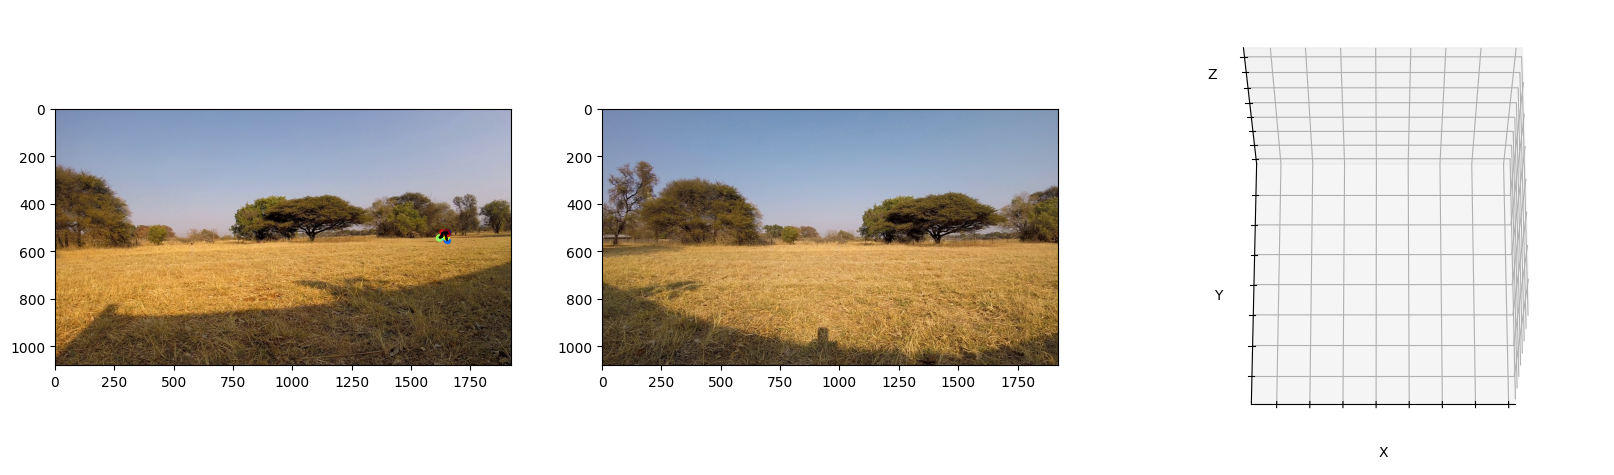

In [43]:
deeplabcut.create_labeled_video_3d(
    config_path,
    ["AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1_DLC_3D.h5"], 
    videofolder="AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated",
    videotype=".mp4",
    #trailpoints=3,
    fps=90,
)

In [ ]:
import os
start_path = os.getcwd()

# Read the config file and related variables
cfg_3d = auxiliaryfunctions.read_config(config_path)
cam_names = cfg_3d["camera_names"]
pcutoff = cfg_3d["pcutoff"]
markerSize = cfg_3d["dotsize"]
alphaValue = cfg_3d["alphaValue"]
cmap = cfg_3d["colormap"]
bodyparts2connect = cfg_3d["skeleton"]
skeleton_color = cfg_3d["skeleton_color"]
scorer_3d = cfg_3d["scorername_3d"]
color_by = "bodypart"  # "bodypart" or "individual"
path = ["AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated/vid1_DLC_3D.h5"]
videofolder = "AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated"
videotype = ".mp4"
trailpoints = 3
fps = 90
file_list = auxiliaryfunctions_3d.Get_list_of_triangulated_and_videoFiles(
    path, videotype, scorer_3d, cam_names, videofolder
)
print(file_list)


[['AcinoSet_2017_08_29_top_jules_run1_1\\dlc_pw_triangulated\\vid1_DLC_3D.h5', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam1.mp4', 'AcinoSet_2017_08_29_top_jules_run1_1/dlc_pw_triangulated\\vid1-cam2.mp4']]


In [7]:
file = file_list[0]
path_h5_file = Path(file[0]).parents[0]
triangulate_file = file[0]
# triangulated file is a list which is always sorted as [triangulated.h5,camera-1.videotype,camera-2.videotype]
# name for output video
file_name = str(Path(triangulate_file).stem)
videooutname = os.path.join(path_h5_file, file_name + ".mp4")

In [8]:
videooutname

'AcinoSet_2017_08_29_top_jules_run1_1\\dlc_pw_triangulated\\vid1_DLC_3D.mp4'

In [11]:
string_to_remove = str(Path(triangulate_file).suffix)
pickle_file = triangulate_file.replace(string_to_remove, "_meta.pickle")
metadata_ = auxiliaryfunctions_3d.LoadMetadata3d(pickle_file)

In [14]:
base_filename_cam1 = str(Path(file[1]).stem).split(videotype)[
    0
]  # required for searching the filtered file
base_filename_cam2 = str(Path(file[2]).stem).split(videotype)[
    0
]  # required for searching the filtered file
cam1_view_video = file[1]
cam2_view_video = file[2]
cam1_scorer = metadata_["scorer_name"][cam_names[0]]
cam2_scorer = metadata_["scorer_name"][cam_names[1]]
print(
    "Creating 3D video from %s and %s using %s"
    % (
        Path(cam1_view_video).name,
        Path(cam2_view_video).name,
        Path(triangulate_file).name,
    )
)

Creating 3D video from vid1-cam1.mp4 and vid1-cam2.mp4 using vid1_DLC_3D.h5


In [15]:
import glob
from deeplabcut.utils.auxfun_videos import VideoReader

# Read the video files and corresponfing h5 files
vid_cam1 = VideoReader(cam1_view_video)
vid_cam2 = VideoReader(cam2_view_video)

print(
    "Using unfiltered predictions."
)
df_cam1 = pd.read_hdf(
    glob.glob(
        os.path.join(
            path_h5_file, str(base_filename_cam1 + cam1_scorer + "*.h5")
        )
    )[0]
)
df_cam2 = pd.read_hdf(
    glob.glob(
        os.path.join(
            path_h5_file, str(base_filename_cam2 + cam2_scorer + "*.h5")
        )
    )[0]
)

df_3d = pd.read_hdf(triangulate_file)


Using unfiltered predictions.


In [20]:
num_animals = 1
start = 0
end = None
if end is None:
    end = len(df_3d)  # All the frames
end = min(end, min(len(vid_cam1), len(vid_cam2)))
frames = list(range(start, end))
output_folder = Path(os.path.join(path_h5_file, "temp_" + file_name))
output_folder.mkdir(parents=True, exist_ok=True)

In [22]:
# Flatten the list of bodyparts to connect
bodyparts2plot = list(
    np.unique([val for sublist in bodyparts2connect for val in sublist])
)
bodyparts2plot 

['l_back_ankle',
 'l_back_knee',
 'l_back_paw',
 'l_eye',
 'l_front_ankle',
 'l_front_knee',
 'l_hip',
 'l_shoulder',
 'neck_base',
 'nose',
 'r_back_ankle',
 'r_back_knee',
 'r_back_paw',
 'r_eye',
 'r_front_ankle',
 'r_front_knee',
 'r_front_paw',
 'r_hip',
 'r_shoulder',
 'spine',
 'tail1',
 'tail2',
 'tail_base']

In [24]:
# Format data
mask2d = df_cam1.columns.get_level_values("bodyparts").isin(bodyparts2plot)
xy1 = (
    df_cam1.iloc[: len(df_3d)]
    .loc[:, mask2d]
    .to_numpy()
    .reshape((len(df_3d), -1, 3))
)
visible1 = xy1[..., 2] >= pcutoff
xy1[~visible1] = np.nan
xy2 = (
    df_cam2.iloc[: len(df_3d)]
    .loc[:, mask2d]
    .to_numpy()
    .reshape((len(df_3d), -1, 3))
)
visible2 = xy2[..., 2] >= pcutoff
xy2[~visible2] = np.nan
mask = df_3d.columns.get_level_values("bodyparts").isin(bodyparts2plot)
xyz = df_3d.loc[:, mask].to_numpy().reshape((len(df_3d), -1, 3))
xyz[~(visible1 & visible2)] = np.nan

bpts = df_3d.columns.get_level_values("bodyparts")[mask][::3]
links = make_labeled_video.get_segment_indices(
    bodyparts2connect,
    bpts,
)
ind_links = tuple(zip(*links))

In [29]:
if color_by == "bodypart":
    color = plt.cm.get_cmap(cmap, len(bodyparts2plot))
    colors_ = color(range(len(bodyparts2plot)))
    colors = np.tile(colors_, (num_animals, 1))
elif color_by == "individual":
    color = plt.cm.get_cmap(cmap, num_animals)
    colors_ = color(range(num_animals))
    colors = np.repeat(colors_, len(bodyparts2plot), axis=0)


C:\Users\locha\AppData\Local\Temp\ipykernel_316164\3214959606.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap(cmap, len(bodyparts2plot))


In [34]:
xlim = None
ylim = None
zlim = None
dpi = 300
figsize=(20, 8)
view=(-113, -270)
draw_skeleton = True

# Trick to force equal aspect ratio of 3D plots
minmax = np.nanpercentile(xyz[frames], q=[25, 75], axis=(0, 1)).T
minmax *= 1.1
minmax_range = (minmax[:, 1] - minmax[:, 0]).max() / 2
if xlim is None:
    mid_x = np.mean(minmax[0])
    xlim = mid_x - minmax_range, mid_x + minmax_range
if ylim is None:
    mid_y = np.mean(minmax[1])
    ylim = mid_y - minmax_range, mid_y + minmax_range
if zlim is None:
    mid_z = np.mean(minmax[2])
    zlim = mid_z - minmax_range, mid_z + minmax_range

print(xlim, ylim, zlim)

(-20.548954509957497, 132.13255211346066) (-74.172383165293, 78.50912345812516) (51.92395654526646, 204.60546316868462)


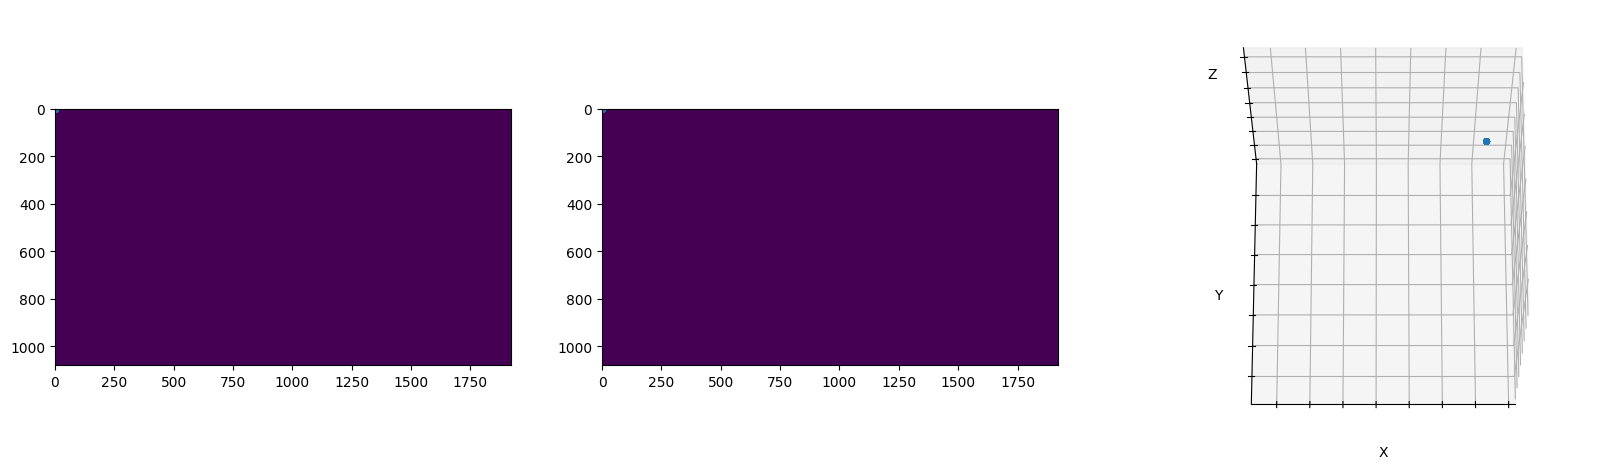

In [39]:
# Set up the matplotlib figure beforehand
fig, axes1, axes2, axes3 = plotting3D.set_up_grid(figsize, xlim, ylim, zlim, view)
points_2d1 = axes1.scatter(
    *np.zeros((2, len(bodyparts2plot))),
    s=markerSize,
    alpha=alphaValue,
)
im1 = axes1.imshow(np.zeros((vid_cam1.height, vid_cam1.width)))
points_2d2 = axes2.scatter(
    *np.zeros((2, len(bodyparts2plot))),
    s=markerSize,
    alpha=alphaValue,
)
im2 = axes2.imshow(np.zeros((vid_cam2.height, vid_cam2.width)))
points_3d = axes3.scatter(
    *np.zeros((3, len(bodyparts2plot))),
    s=markerSize,
    alpha=alphaValue,
)

In [40]:
if draw_skeleton:
    # Set up skeleton LineCollections
    segs = np.zeros((2, len(ind_links), 2))
    coll1 = LineCollection(segs, colors=skeleton_color)
    coll2 = LineCollection(segs, colors=skeleton_color)
    axes1.add_collection(coll1)
    axes2.add_collection(coll2)
    segs = np.zeros((2, len(ind_links), 3))
    coll_3d = Line3DCollection(segs, colors=skeleton_color)
    axes3.add_collection(coll_3d)

In [ ]:
writer = FFMpegWriter(fps=fps)
with writer.saving(fig, videooutname, dpi=dpi):
    for k in tqdm(frames):
        print("Processing frame %d/%d" % (k + 1, end))
        vid_cam1.set_to_frame(k)
        vid_cam2.set_to_frame(k)
        frame_cam1 = vid_cam1.read_frame()
        frame_cam2 = vid_cam2.read_frame()
        if frame_cam1 is None or frame_cam2 is None:
            raise IOError("A video frame is empty.")

        im1.set_data(frame_cam1)
        im2.set_data(frame_cam2)

        sl = slice(max(0, k - trailpoints), k + 1)
        print("Trailpoints slice:", sl)
        coords3d = xyz[sl]
        print("Coords3d shape:", coords3d.shape)
        coords1 = xy1[sl, :, :2]
        coords2 = xy2[sl, :, :2]
        print("xyz[k] shape:", xyz[k].shape)
        print("ind_links:", ind_links)
        print("Max index in ind_links:", np.max(ind_links))

        points_3d._offsets3d = coords3d.reshape((-1, 3)).T
        points_3d.set_color(colors)
        points_2d1.set_offsets(coords1.reshape((-1, 2)))
        points_2d1.set_color(colors)
        points_2d2.set_offsets(coords2.reshape((-1, 2)))
        points_2d2.set_color(colors)
        if draw_skeleton:
            segs3d = xyz[k][tuple([ind_links])].swapaxes(0, 1)
            coll_3d.set_segments(segs3d)
            segs1 = xy1[k, :, :2][tuple([ind_links])].swapaxes(0, 1)
            coll1.set_segments(segs1)
            segs2 = xy2[k, :, :2][tuple([ind_links])].swapaxes(0, 1)
            coll2.set_segments(segs2)

        writer.grab_frame()

  0%|          | 0/143 [00:00<?, ?it/s]

Processing frame 1/143
Trailpoints slice: slice(0, 1, None)
Coords3d shape: (1, 23, 3)


  1%|          | 1/143 [00:01<02:31,  1.06s/it]

Processing frame 2/143
Trailpoints slice: slice(0, 2, None)
Coords3d shape: (2, 23, 3)


  1%|          | 1/143 [00:01<04:22,  1.85s/it]


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (23,4)  and requested shape (46,4)